In [76]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
%autoreload 2

In [35]:

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from trainer.segnet import build_encoder_decoder, build_refinement
from trainer.utils import get_final_output
from trainer.data_generator import composite4, valid_gen
from trainer.utils import overall_loss, alpha_prediction_loss, compositional_loss

In [2]:
import trainer.data_generator

In [14]:
img_rows, img_cols = 320, 320
channel = 3

#composite:
#checkpoint_path = '/Users/erez/Downloads/deep_image_matting_20190513_195202_checkpoints_encoder_decoder.44-0.0062.hdf5'

#no composite
#checkpoint_path = '/Users/erez/Downloads/deep_image_matting_20190515_121805_checkpoints_encoder_decoder.41-0.0093.hdf5'

#composite/noise: 
checkpoint_path = '/Users/erez/Downloads/deep_image_matting_20190522_103645_checkpoints_encoder_decoder.29-0.0065.hdf5'



In [15]:
final = build_encoder_decoder()
#final = build_refinement(final)
final.load_weights(checkpoint_path)

#print(final.summary())

In [16]:
final.compile(optimizer='nadam', loss=alpha_prediction_loss)


In [27]:
sample = valid_gen(1)[0]

Garbage collected batch 0 in 0.40s


In [32]:
sample[0].shape

(1, 320, 320, 3)

In [22]:
model_input = sample[0]
y_true = sample[1]
img = model_input[0,:,:,0:3]
if channel > 3: 
    trimap = model_input[0,:,:,3]
gt = y_true[0,:,:,0]

In [23]:
y_pred = final.predict(model_input)
pred = np.reshape(y_pred, (img_rows, img_cols))
pred = pred * 255.0
pred = pred.astype(np.uint8)

#if channel > 3: 
    #out = get_final_output(out, trimap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


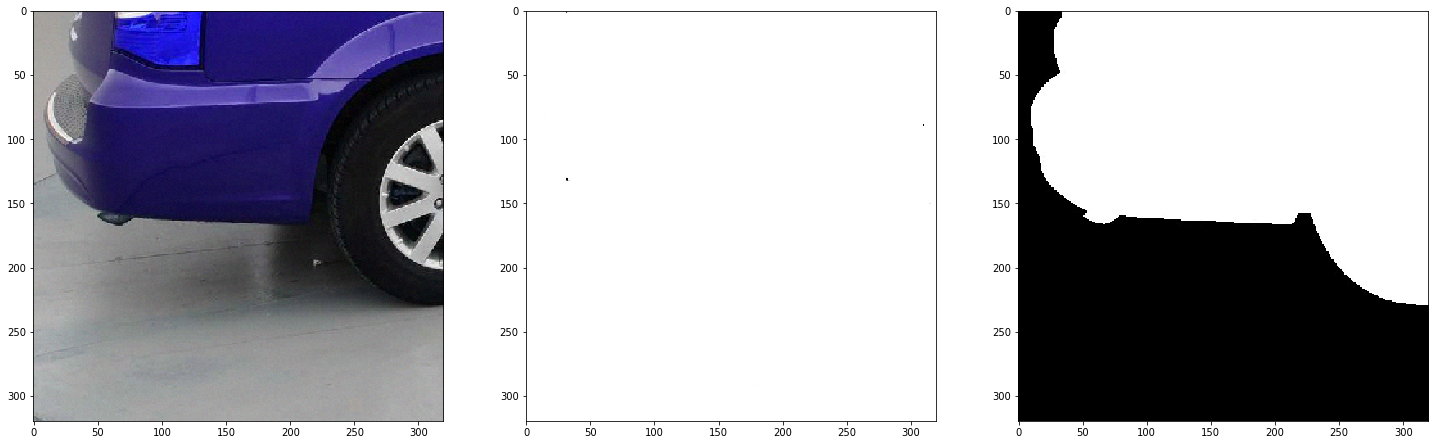

In [24]:
f, ax = plt.subplots(1,3,figsize=(25,25))

ax[0].imshow(img)
ax[1].imshow(pred, cmap = 'gray')
ax[2].imshow(gt, cmap = 'gray')

In [190]:
sess = tf.InteractiveSession()
scalar = alpha_prediction_loss(y_true, y_pred).eval()
sess.close
print(scalar)

0.0117655825


In [26]:
x = 'erez'

if x = 'erez':
    print('asdfasdf')

SyntaxError: invalid syntax (<ipython-input-26-078641e11317>, line 3)

In [113]:
y_true.shape

(1, 320, 320, 11)

In [215]:
mask = y_true[0, :, :, 1]
image = y_true[0, :, :, 2:5]
fg = y_true[0, :, :, 5:8]
bg = y_true[0, :, :, 8:11]

alpha = y_pred[0,:,:,0]

In [216]:
alpha3 = np.stack([alpha, alpha, alpha], axis = 2)

c_p = cv.multiply(alpha3,fg) + cv.multiply((1.0 - alpha3),bg)

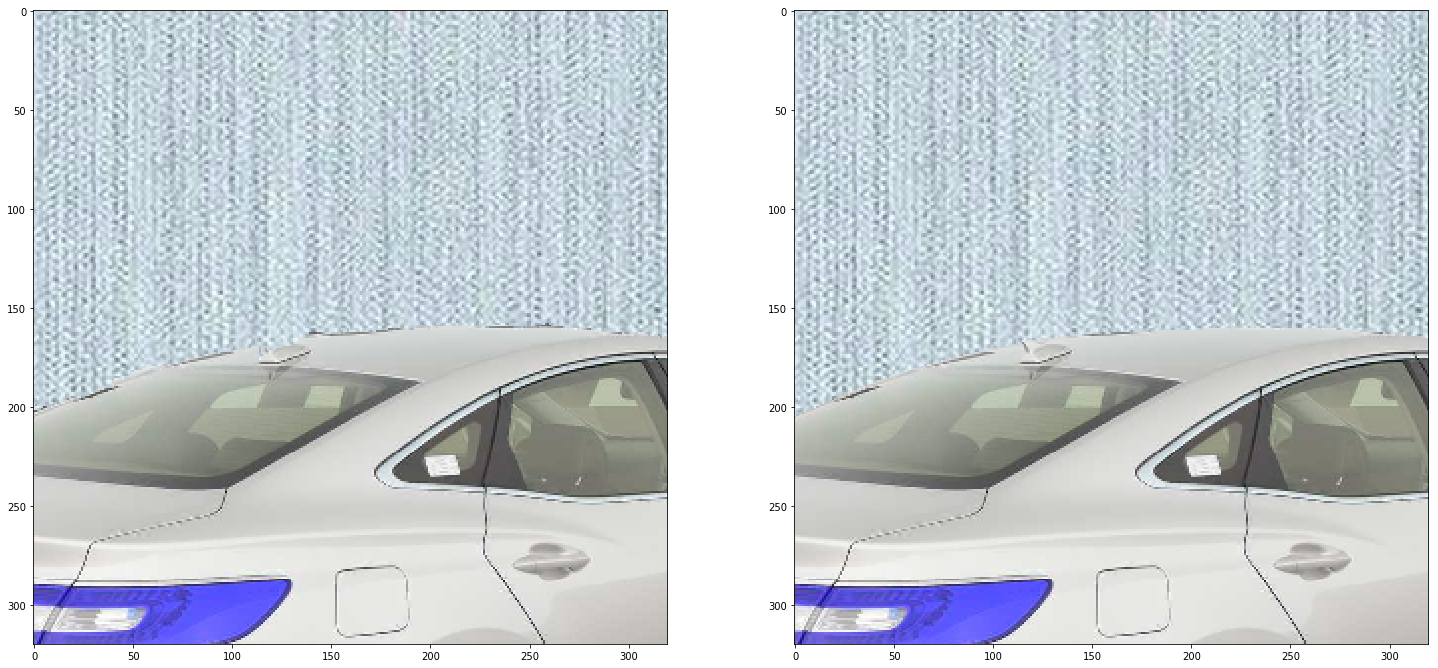

In [217]:
f, ax = plt.subplots(1,2,figsize=(25,25))

ax[0].imshow(c_p/255)
ax[1].imshow(image/255, cmap = 'gray')


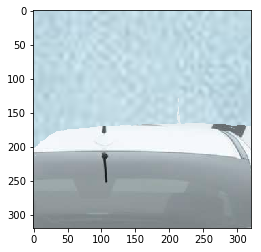

In [123]:
plt.imshow(c_p[0,:,:,:]/255)

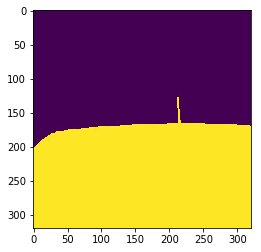

In [134]:
plt.imshow(y_true[0,:,:,0])

In [34]:
x = np.array([])